# 딥러닝 메인 프로젝트: 꽃 분류
- 2025.12.08(Mon)
- 모두의 연구소 데싸6기
- Mihyn Lee

✅ 결과 요약 및 회고는 깃허브 **'251208_Readme_Result_꽃분류.md'** 파일에서 확인 부탁 드립니다.

# 1차 시도

## Step 1. 데이터셋 내려받기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# 데이터셋 로드 및 분할
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    # 훈련 80%, 검증 10%, 테스트 10%로 분할
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='./data', # 현재 폴더 아래 data 폴더에 저장
    download=True,
    with_info=True,
    as_supervised=True, # 이미지와 라벨(숫자) 쌍으로 가져옴
)

# 데이터 정보 확인
print(f"훈련 데이터 개수: {len(raw_train)}")
print(f"검증 데이터 개수: {len(raw_validation)}")
print(f"테스트 데이터 개수: {len(raw_test)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling data/tf_flowers/incomplete.G91UOG_3.0.1/tf_flowers-train.tfrecord*...:   0%|          | 0/3670 [00:0…

Dataset tf_flowers downloaded and prepared to data/tf_flowers/3.0.1. Subsequent calls will reuse this data.
훈련 데이터 개수: 2936
검증 데이터 개수: 367
테스트 데이터 개수: 367


깃허브 업로드 오류로 아래 코드 삭제 후 제출
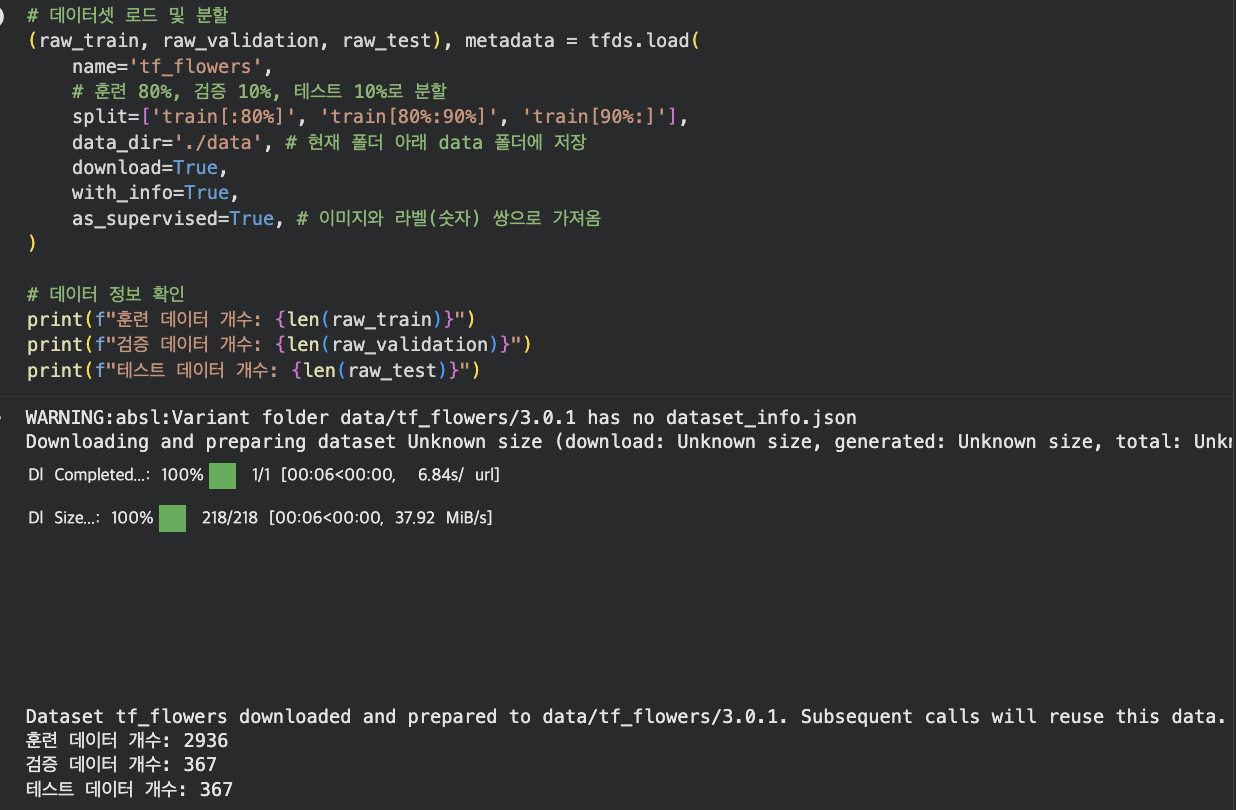

In [3]:
# 데이터셋 구조 및 샘플 확인하기
# 1. 전체 클래스 개수 확인
num_classes = metadata.features['label'].num_classes
print(f"전체 클래스 개수: {num_classes}")

# 2. 클래스 이름 목록 확인
class_names = metadata.features['label'].names
print(f"클래스 이름 목록: {class_names}")

# 3. 특정 숫자 라벨이 어떤 이름인지 확인
for i, name in enumerate(metadata.features['label'].names):
    print(f"라벨 {i}: {name}")

전체 클래스 개수: 5
클래스 이름 목록: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
라벨 0: dandelion
라벨 1: daisy
라벨 2: tulips
라벨 3: sunflowers
라벨 4: roses


In [4]:
# 4. 샘플 데이터 하나를 추출하여 Shape 확인
for image, label in raw_train.take(1):
    print("이미지 데이터 타입:", type(image))
    print("이미지 Shape (h, w, c):", image.shape)
    print("라벨 (숫자):", label.numpy())
    print("라벨 이름:", metadata.features['label'].int2str(label))

이미지 데이터 타입: <class 'tensorflow.python.framework.ops.EagerTensor'>
이미지 Shape (h, w, c): (333, 500, 3)
라벨 (숫자): 2
라벨 이름: tulips


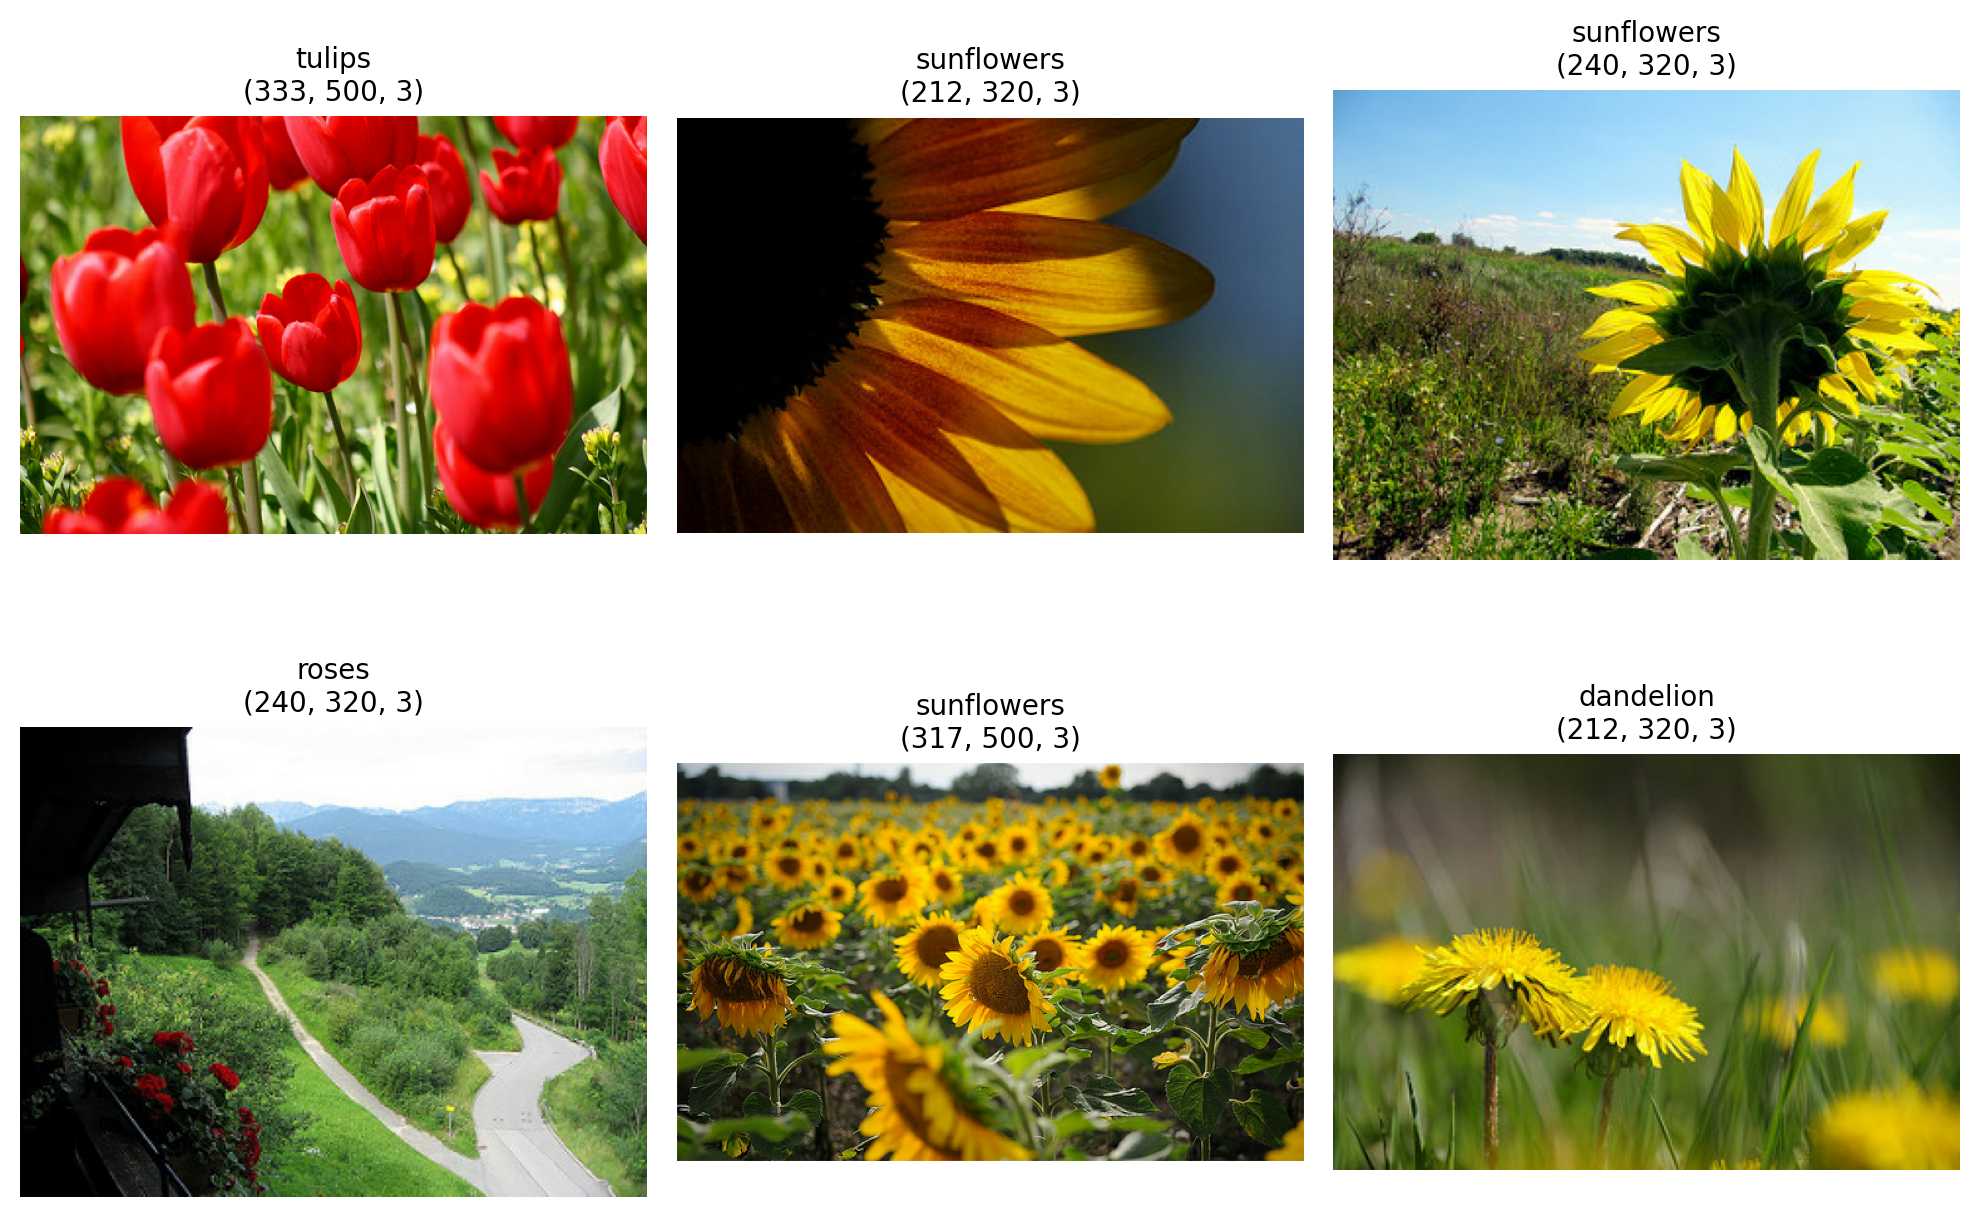

In [7]:
# 5. 여러 샘플 이미지를 시각화하여 확인
plt.figure(figsize=(10, 7))

for i, (image, label) in enumerate(raw_train.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image) # 이미지 출력

    plt.title(f"{metadata.features['label'].int2str(label)}\n{image.shape}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
- 리사이징(Resize): 모든 이미지를 160x160 크기로 통일
- 정규화(Normalization): / 255.0 (0-1 또는 -1-1 사이로 변환)
- 셔플 및 배치(Shuffle & Batch): 데이터를 무작위로 섞고, 모델이 한 번에 학습할 덩어리(Batch)로 묶기

In [8]:
# 이미지 크기 설정 (이후 전이 학습 모델 규격에 맞춤)
IMG_SIZE = 160

def format_example(image, label):
    # 1. 이미지 크기를 160x160으로 조정
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # 2. 픽셀 값 정규화
    image = image / 255.0
    return image, label

# 전처리 함수 적용
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [9]:
# 데이터 섞기 및 배치 처리
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [10]:
# 전처리 결과 확인 (하나의 배치 모양 확인)
for image_batch, label_batch in train_batches.take(1):
    print("배치 이미지 모양:", image_batch.shape)
    print("배치 라벨 모양:", label_batch.shape)

배치 이미지 모양: (32, 160, 160, 3)
배치 라벨 모양: (32,)


## Step 3. 모델 설계하기
- Base Model (사전 학습된 모델): 이미지의 특징(색상, 모양, 질감)을 추출하는 엔진 -> VGG16
- Global Average Pooling & Dense Layer: 추출된 특징을 바탕으로 어떤 꽃인지 결정
- Prediction Layer: 꽃 클래스 5개 적용 및 활성화함수 softmax 사용

In [11]:
# 1. Base Model 불러오기 (VGG16)
# 특징 추출 부분만 가져오기 위해 include_top=False로 설정
base_model = tf.keras.applications.VGG16(input_shape=(160, 160, 3),
                                         include_top=False,
                                         weights='imagenet')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# 2. Base Model 가중치 고정
# 이미 학습된 VGG16의 지식=가중치는 수정되지 않도록 동결
base_model.trainable = False

In [13]:
# 3. 새로운 분류층(Head) 설계
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(units=256, activation='relu')
prediction_layer = tf.keras.layers.Dense(units=5, activation='softmax') # 꽃 클래스 5개

In [14]:
# 4. 모델 결합 (Sequential API)
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [15]:
# 5. 모델 구조 확인
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,301 (56.64 MB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Step 4. 모델 학습시키기

In [16]:
# 초기 모델 컴파일 (Adam 옵티마이저 사용)
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
# 학습 전 초기 모델 성능 평가
validation_steps = 10
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print(f"초기 손실: {loss0:.2f}")
print(f"초기 정확도: {accuracy0:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.1238 - loss: 1.7924
초기 손실: 1.78
초기 정확도: 0.14


In [18]:
# 수렴 속도가 빨라졌으므로 epoch = 5로 수정
EPOCHS = 5

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - accuracy: 0.2680 - loss: 1.5794 - val_accuracy: 0.5504 - val_loss: 1.3514
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.5824 - loss: 1.3128 - val_accuracy: 0.6213 - val_loss: 1.1559
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.6486 - loss: 1.1273 - val_accuracy: 0.6703 - val_loss: 1.0299
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.6695 - loss: 1.0042 - val_accuracy: 0.7030 - val_loss: 0.9453
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.7160 - loss: 0.9239 - val_accuracy: 0.7166 - val_loss: 0.8684


## Step 5. 모델 성능 평가하기

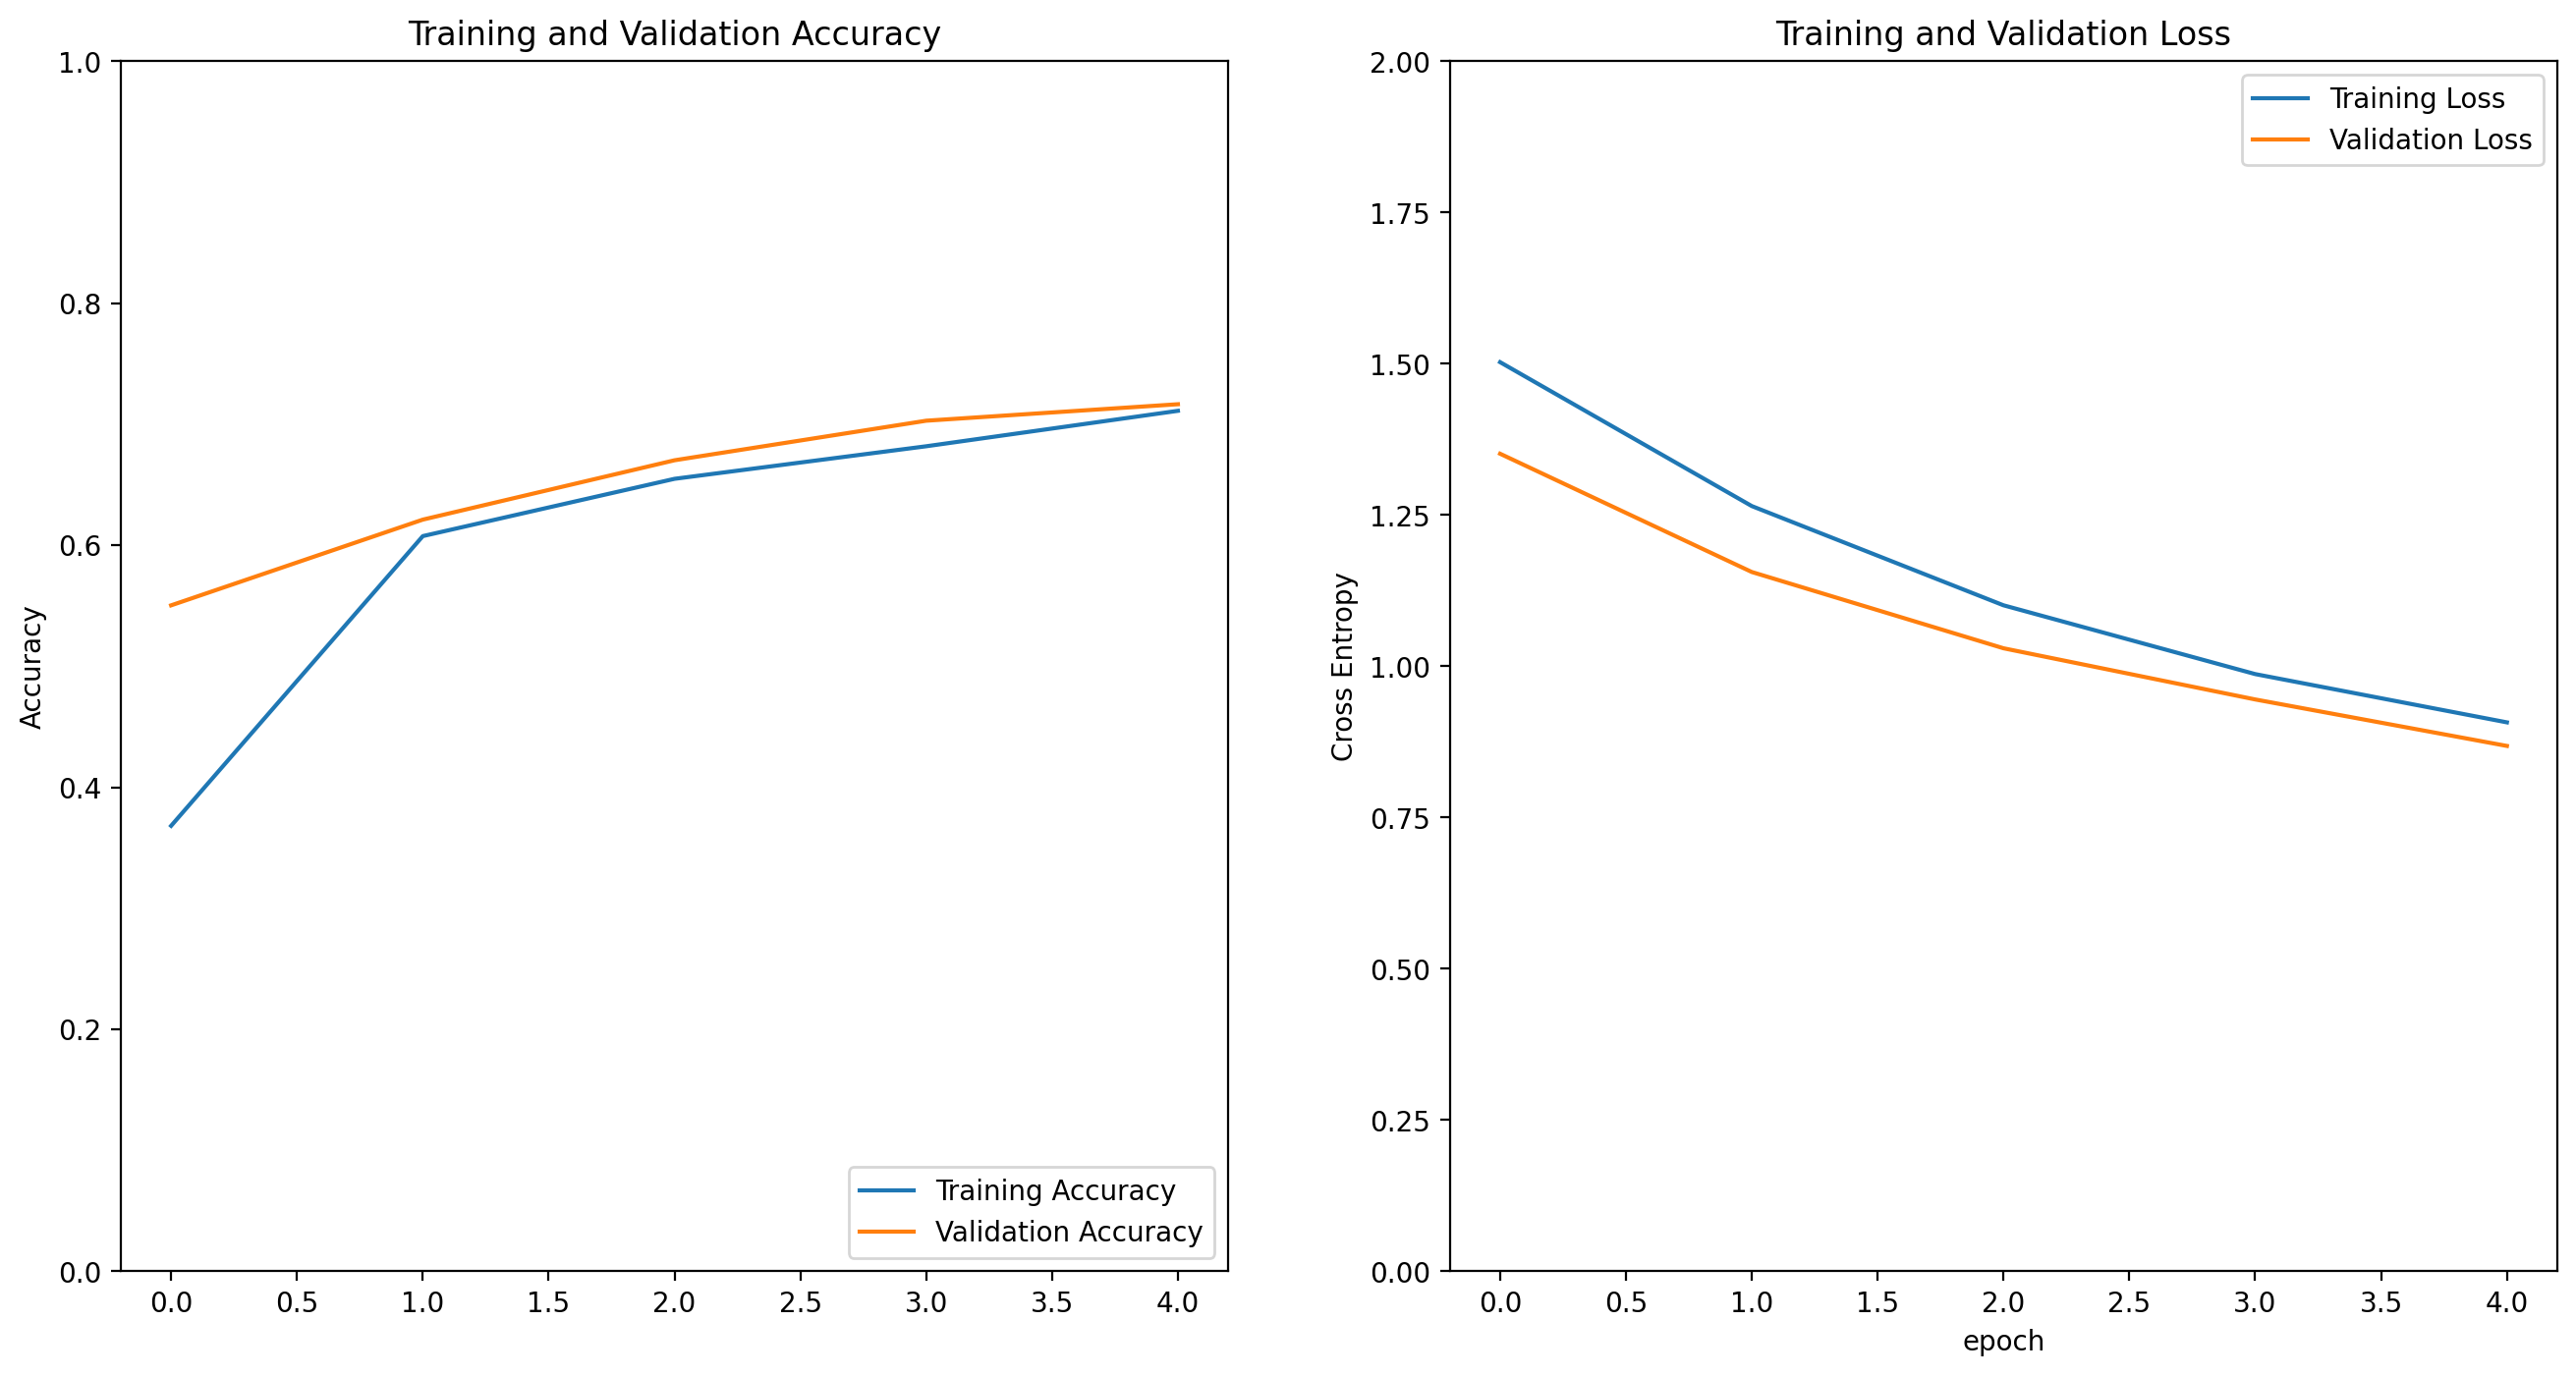

In [19]:
# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 2.0])
plt.xlabel('epoch')
plt.title('Training and Validation Loss')

plt.show()

## Step 6. 모델 활용하기
- 테스트 데이터셋에서 한 배치(32장)를 꺼내 실제로 모델이 어떻게 예측했는지 시각적으로 확인

In [20]:
import numpy as np

# 1. 테스트 데이터에서 한 배치 추출 및 예측
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions_raw = model.predict(image_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step


In [21]:
# 2. 확률 분포 중 가장 높은 클래스 인덱스 선택
predictions = np.argmax(predictions_raw, axis=1)

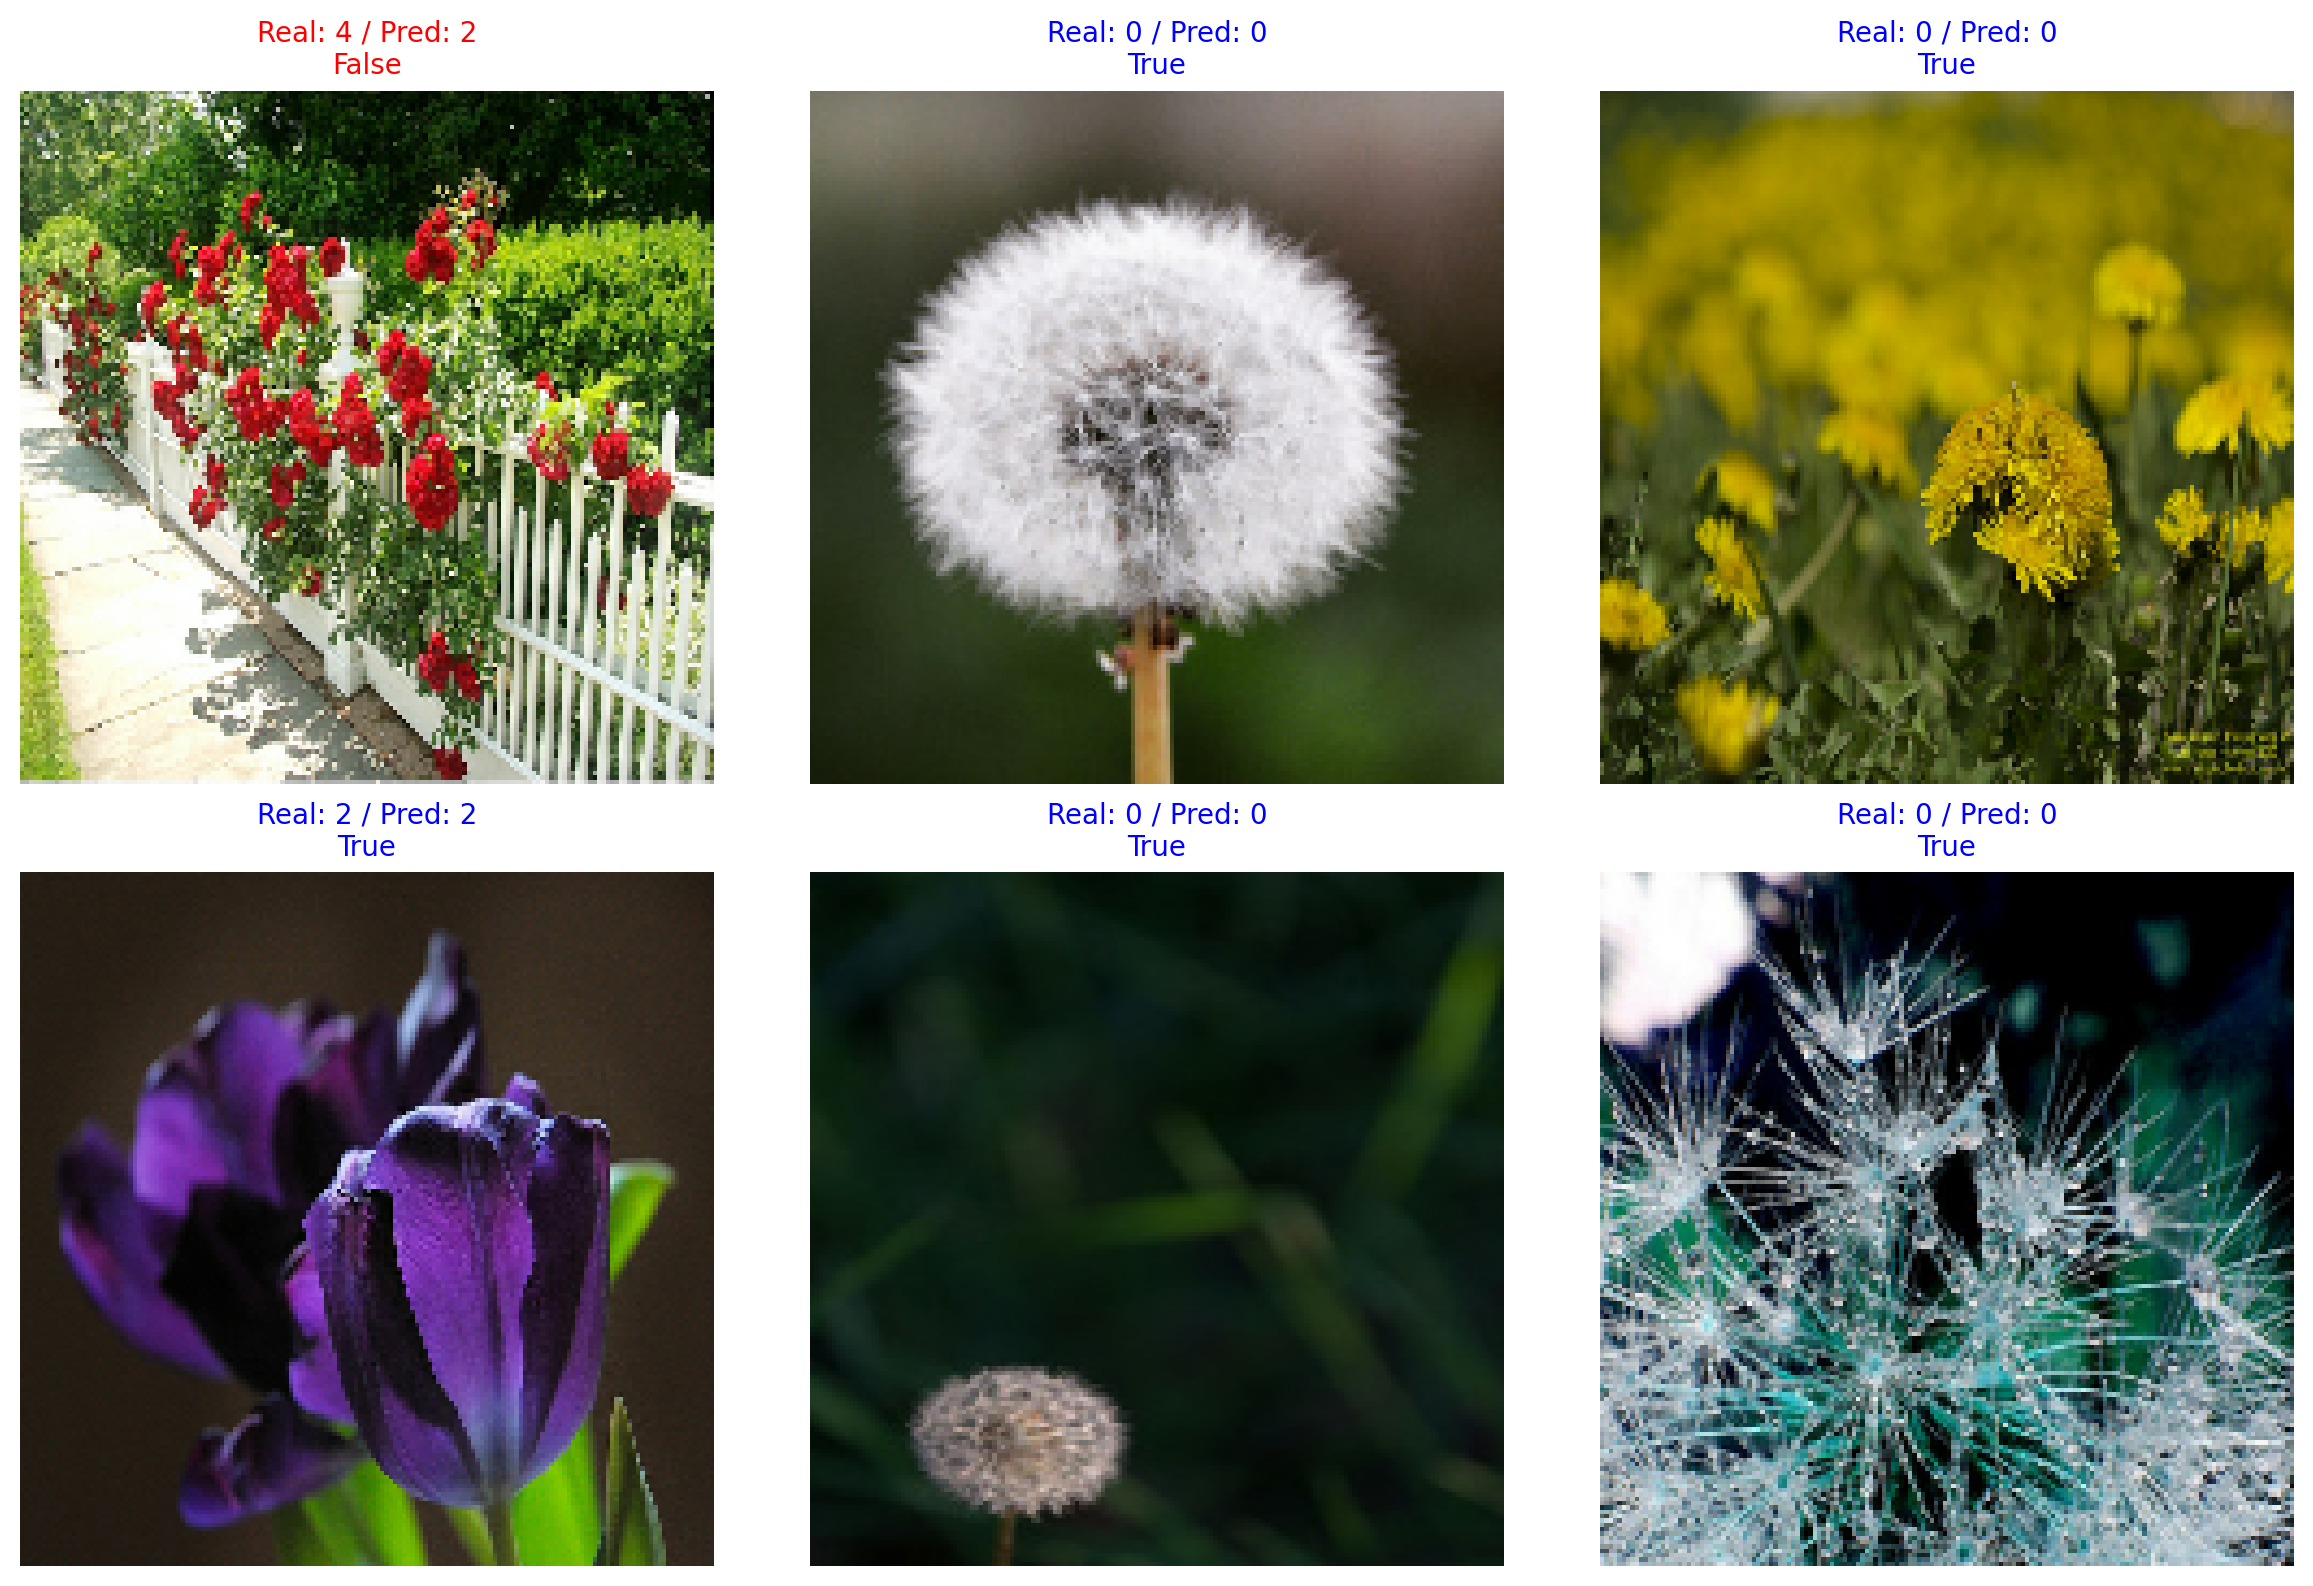

In [22]:
# 3. 이미지 시각화 및 예측 결과 표시
plt.figure(figsize=(12, 8))
for idx, (image, label, prediction) in enumerate(list(zip(images, labels, predictions))[:6]):
    plt.subplot(2, 3, idx + 1)
    plt.imshow(image)

    correct = (label == prediction)
    title = f'Real: {label} / Pred: {prediction}\n{correct}'

    color = 'blue' if correct else 'red'
    plt.title(title, fontdict={'color': color}, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:
# 4. 한 배치에 대한 정확도 계산
count = np.sum(labels.numpy() == predictions)
print(f"배치 정확도: {count / len(labels) * 100:.2f}%")

배치 정확도: 71.88%


[1차 시도 결과 요약]
- epoch 1차 정확도 0.2680 -> 5차 0.7160로 상승했지만, epoch 중반부터 정체 (배치 정확도도 71%로 낮은 편)
- 은닉층 중, 상단부만으로는 꽃의 미세한 차이를 구별하는 모델의 능력을 끌어올리기 어려워보임
- 게다가 초반부터 코드에서 약간 의심이 갔던 base_model.trainable = True 설정으로 인해, 하위 레이어도 학습하게끔 재도전
- 또한 VGG16은 파라미터가 매우 많아 계산량이 큰 편으로 학습 시간이 약 1시간 40분 소요되어 다른 모델로 베이스 모델 교체하여 재진행

# 2차 시도

## Step 7. 베이스모델 교체
- MobileNetV2: 경량화 모델로 학습 속도가 획기적으로 빨라지면서도 비슷하거나 더 높은 정확도를 얻을 수 있다고 함
- 코랩 하드웨어 가속 사용 설정 변경: 기존 CPU -> 변경 T4 GPU

In [24]:
# 베이스모델 교체하여 재진행
# 1. 가볍고 빠른 MobileNetV2 사용
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False # 일단 가중치 고정

# 2. 모델 재구성 - Dropout 추가로 Regularization 적용 (과적합 방지)
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.2), # 과적합 방지
  tf.keras.layers.Dense(5, activation='softmax')
])

# 3. 모델 컴파일 (옵티마이저 Adam)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
# 전이 학습
# 고정된 베이스 모델 위에서 분류층만 빠르게 학습

initial_epochs = 5
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 293ms/step - accuracy: 0.5258 - loss: 1.2137 - val_accuracy: 0.8447 - val_loss: 0.4962
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8301 - loss: 0.4762 - val_accuracy: 0.8420 - val_loss: 0.4169
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8592 - loss: 0.3818 - val_accuracy: 0.8719 - val_loss: 0.3936
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8904 - loss: 0.3031 - val_accuracy: 0.8801 - val_loss: 0.3514
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8997 - loss: 0.2805 - val_accuracy: 0.8801 - val_loss: 0.3418


In [26]:
# 파인튜닝 (Fine-tuning) - 성능 극대화
# 베이스 모델의 뒷부분 레이어 일부를 해제하여 꽃의 미세한 특징을 학습하도록 설정
# 1. 베이스 모델의 학습 가능 상태 해제 (1차 시도에서는 False로 진행했음)
base_model.trainable = True

# 2. 몇 번째 레이어부터 파인튜닝할지 결정 (MobileNetV2는 총 154개 층)
# 약 100번째 층 이후만 학습 가능하게 설정
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 3. 컴파일 (학습률을 기존보다 훨씬 많이(1/10) 낮춰서 진행)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 4. 추가 파인튜닝 학습 시작
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1], # 이전 학습 끝난 지점부터 시작
                         validation_data=validation_batches)

Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.7811 - loss: 0.6066 - val_accuracy: 0.8747 - val_loss: 0.3338
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8658 - loss: 0.3802 - val_accuracy: 0.8719 - val_loss: 0.3249
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8826 - loss: 0.3213 - val_accuracy: 0.8719 - val_loss: 0.3201
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9038 - loss: 0.2774 - val_accuracy: 0.8665 - val_loss: 0.3178
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9339 - loss: 0.2085 - val_accuracy: 0.8638 - val_loss: 0.3160
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9418 - loss: 0.1819 - val_accuracy: 0.8556 - val_loss: 0.3175


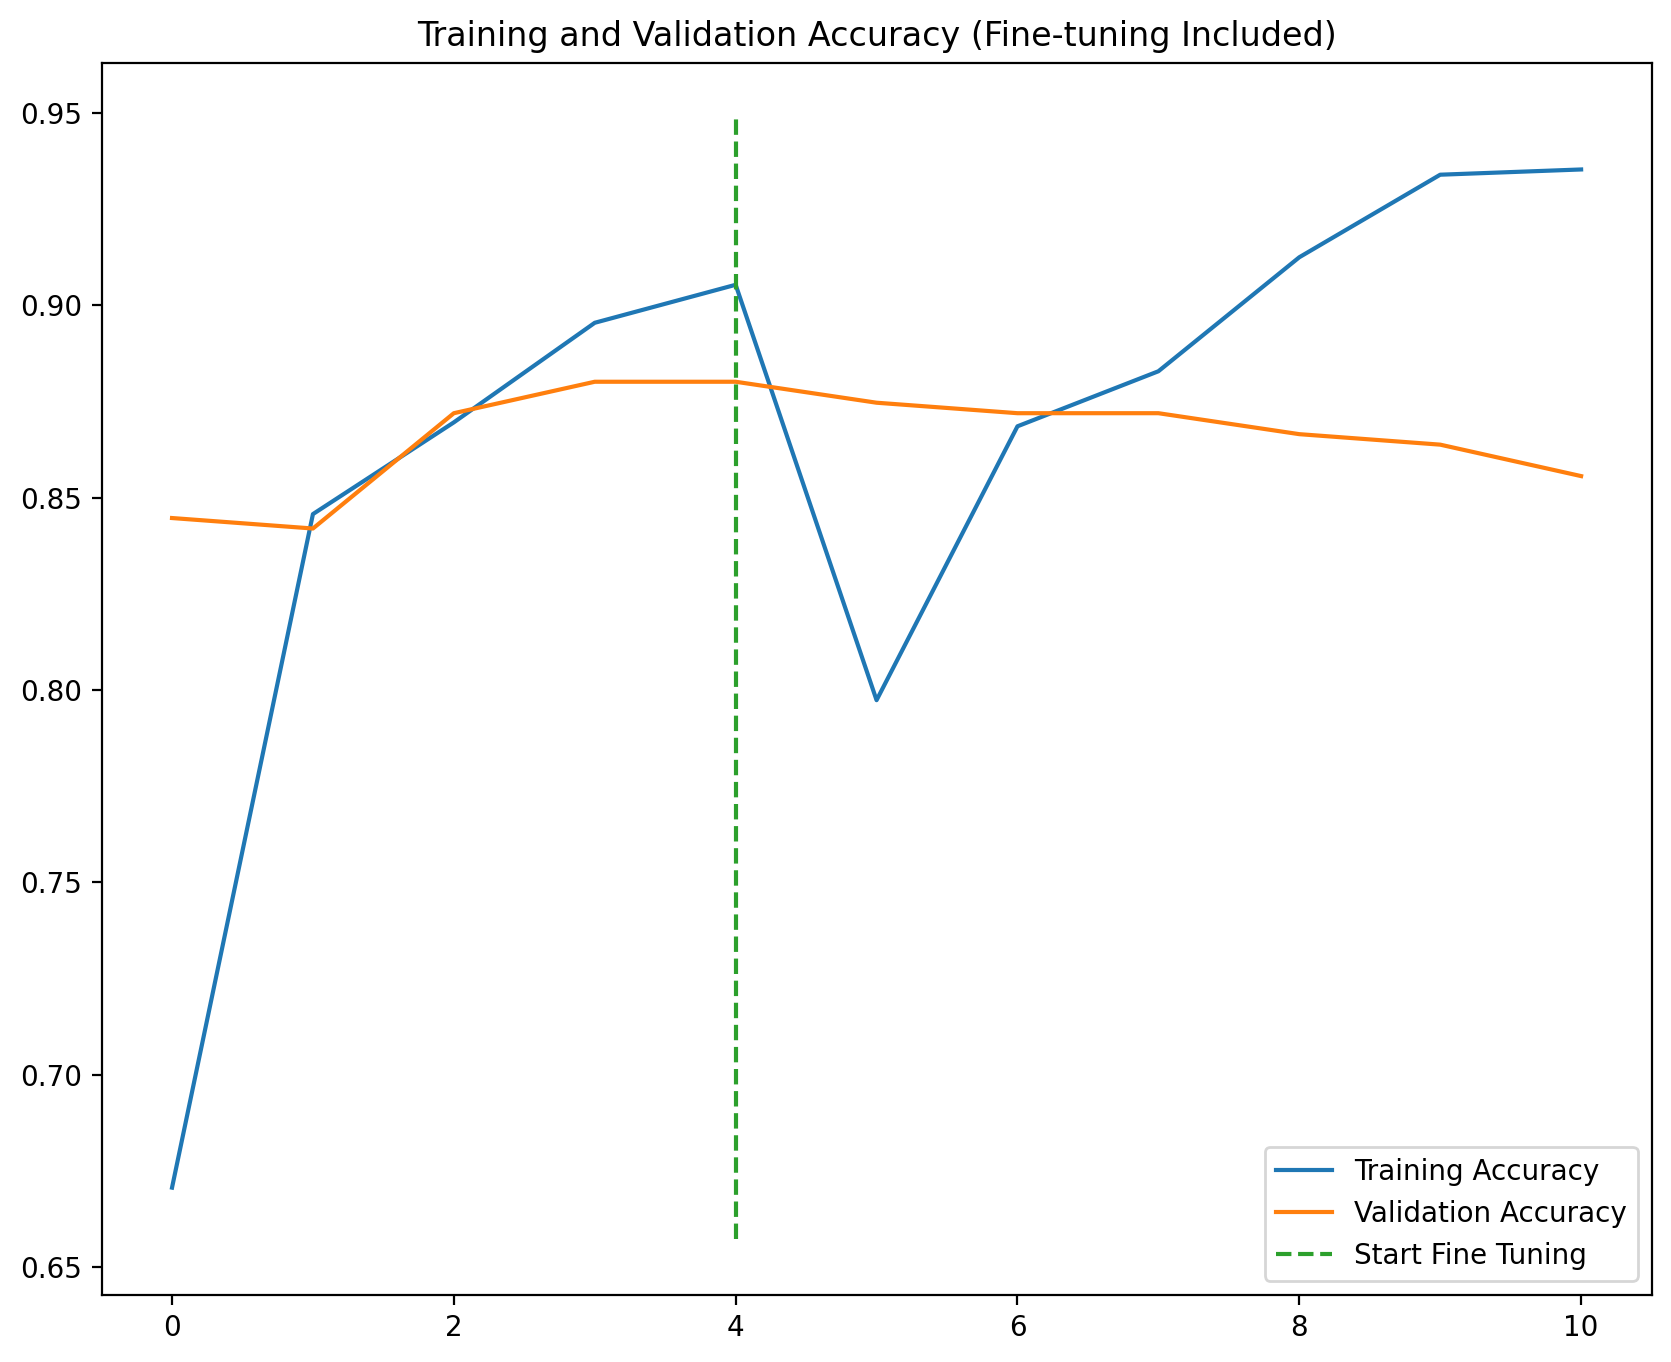

In [27]:
# 2차 모델 성능 평가 및 시각화
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(10, 8))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Fine-tuning Included)')
plt.show()

[ 2차 모델 결과 요약 ]
- VGG16에서 MobileNetV2를 적용하면서 학습 시간 대폭 축소 (1분 내) => 모델 파라미터수 최적화의 결과
- Train 94%, Val. 86% -> 단, 과적합 검증 필요

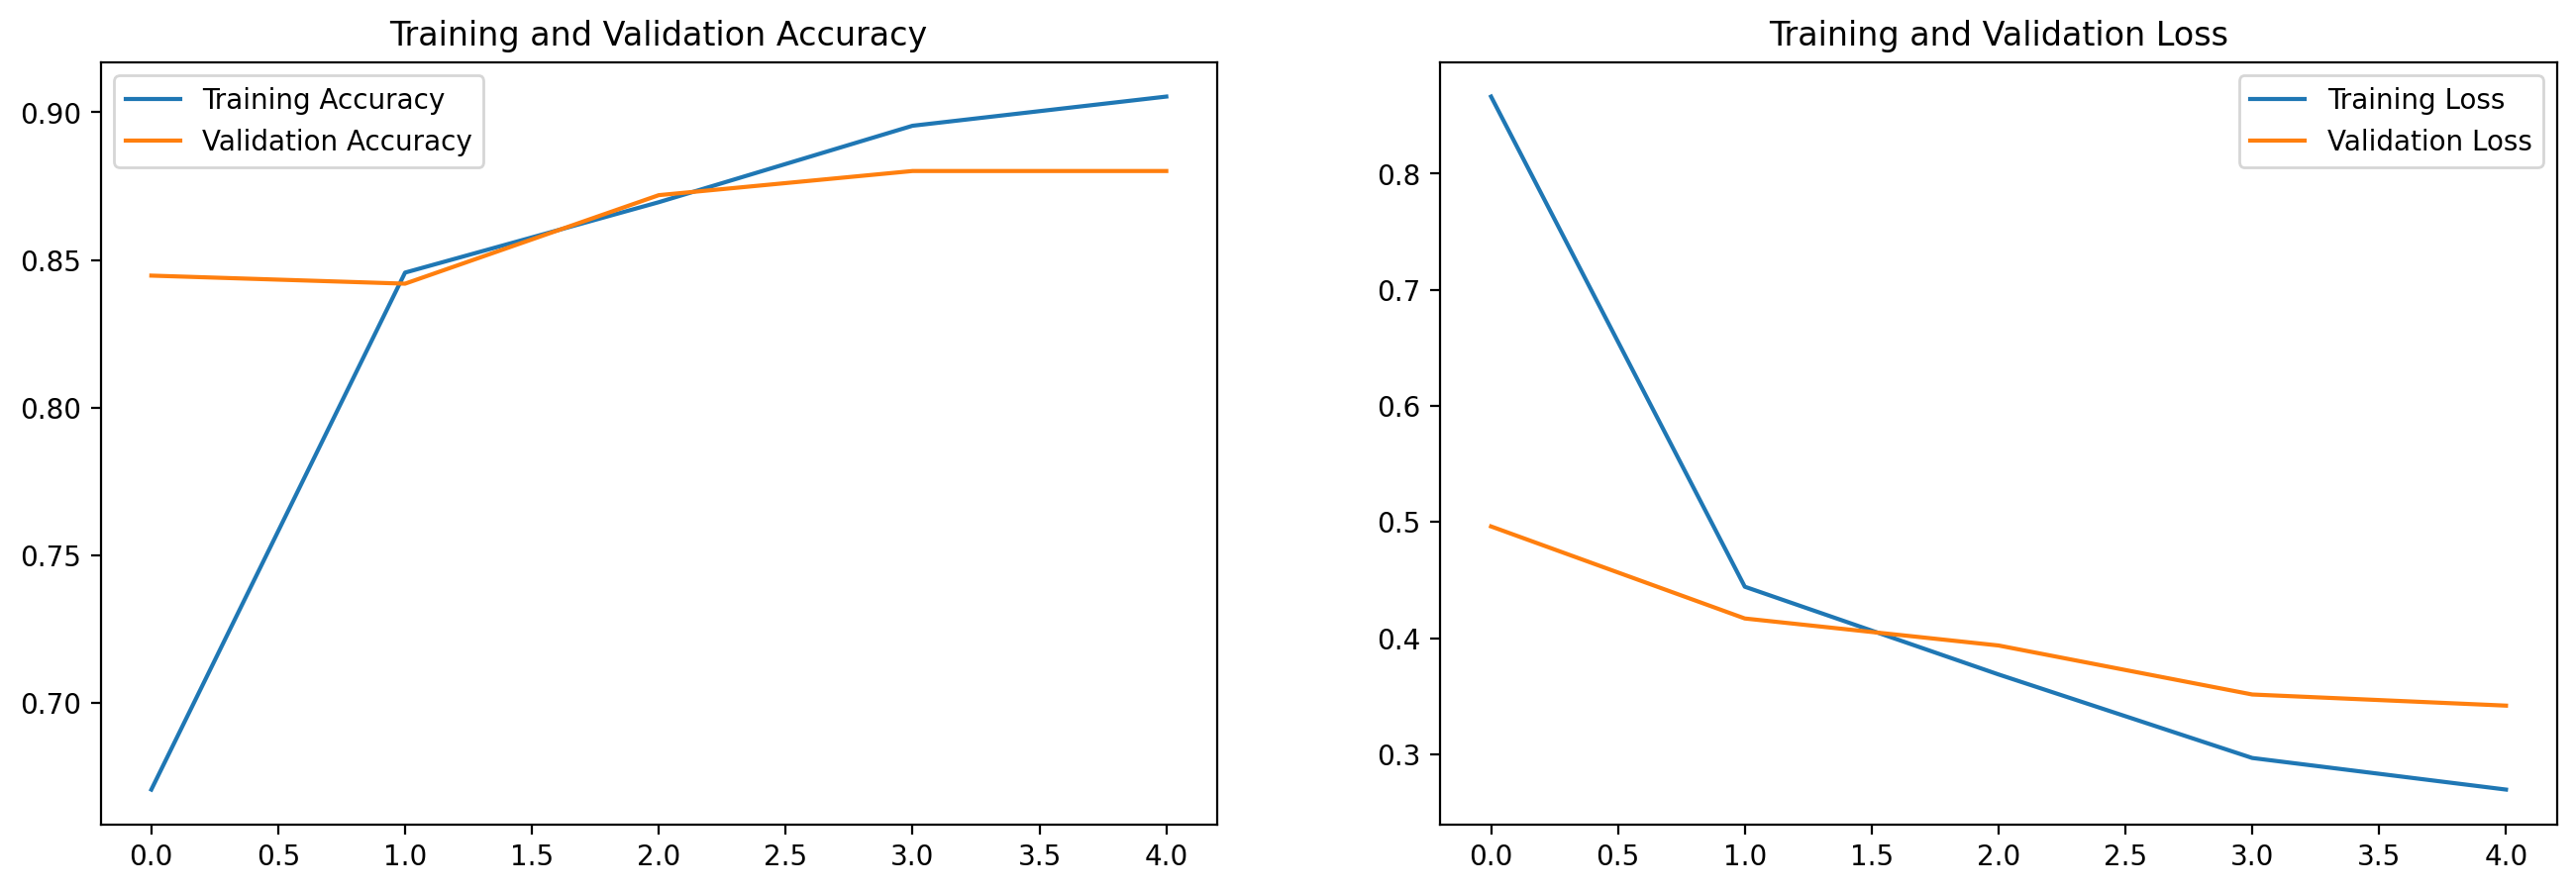

In [28]:
# 2차 모델 성능 시각화 최종 정리
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 5))

    # Accuracy 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_history(history)

In [29]:
# 한 배치에 대한 정확도 계산

# 테스트 데이터셋에서 한 배치(32장)를 추출
for image_batch, label_batch in test_batches.take(1):
    # 모델을 사용해 예측 수행 (각 클래스별 확률값이 나옴)
    predictions_raw = model.predict(image_batch)

    # 확률값 중 가장 높은 값의 인덱스(0~4)를 선택 (Argmax)
    # predictions_raw.shape: (32, 5) -> predictions.shape: (32,)
    predictions = np.argmax(predictions_raw, axis=1)

    # 실제 정답(labels)과 예측값(predictions) 비교
    # label_batch는 텐서 형태이므로 numpy()로 변환하여 비교
    correct_count = np.sum(label_batch.numpy() == predictions)

    # 정확도 계산 및 출력
    total_count = len(label_batch)
    batch_accuracy = (correct_count / total_count) * 100

    print(f"테스트 배치 내 정답 개수: {correct_count} / {total_count}")
    print(f"현재 배치 정확도: {batch_accuracy:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
테스트 배치 내 정답 개수: 27 / 32
현재 배치 정확도: 84.38%


[ 2차 모델 결과 요약(2) ]
- 1차 71% 대비 2차 84%로 베이스모델 변경 및 파라미터 수정이 성공적으로 작동하였으나, \
  사람이 봐도 헷갈릴만한 사진들을 모델도 헷갈려하는 듯..
- 프로젝트 목표인 85% 달성을 위해 미세조정해보기 \
  (특히 2차에서 안해본 base_model.trainable = True 써보기)

# 3차 시도

## Step 8. 3차 시도 (85%를 향해)

In [30]:
# 1차에서 시간이 너무 오래 소요되었어서, Early Stopping 콜백 정의
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',      # 검증 정확도를 기준으로 모니터링
    patience=3,                  # 성능 향상이 없더라도 3에포크는 더 지켜봄
    restore_best_weights=True,   # 학습 종료 후 가장 성적이 좋았던 때의 가중치로 복구
    verbose=1
)

# 2. 동결 해제 범위 확대 (레이어 80번부터)
base_model.trainable = True
fine_tune_at = 80 # 2차 때는 100이었음
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 3. 낮은 학습률로 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4. 파인튜닝 학습 수행
fine_tune_epochs_extra = 15
total_epochs_final = history_fine.epoch[-1] + fine_tune_epochs_extra + 1

history_final = model.fit(
    train_batches,
    epochs=total_epochs_final,
    initial_epoch=history_fine.epoch[-1] + 1,
    validation_data=validation_batches,
    callbacks=[early_stopping]
)

Epoch 11/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 262ms/step - accuracy: 0.9482 - loss: 0.1798 - val_accuracy: 0.8610 - val_loss: 0.3103
Epoch 12/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9567 - loss: 0.1412 - val_accuracy: 0.8719 - val_loss: 0.3107
Epoch 13/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9673 - loss: 0.1219 - val_accuracy: 0.8801 - val_loss: 0.3025
Epoch 14/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9747 - loss: 0.1026 - val_accuracy: 0.8828 - val_loss: 0.3042
Epoch 15/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9761 - loss: 0.0977 - val_accuracy: 0.8828 - val_loss: 0.3053
Epoch 16/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9831 - loss: 0.0846 - val_accuracy: 0.8883 - val_loss: 0.2988
Epoch 17/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9861 - loss: 0.0725 - val_accuracy: 0.8910 - val_loss: 0.2985
Epoch 18/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9877 - loss: 0.0594 - val_accuracy: 

- MobileNetV2의 앞부분 층들은 아주 일반적인 특징(직선, 점)을 감지함
- 중간층(80 ~ 100)부터는 꽃잎의 곡선이나 잎사귀의 패턴 같은 도메인 특화 특징을 다루기 때문에, 이 부분을 더 열어주는 것이 정확도 향상의 핵심

In [31]:
# 목표 달성 여부 재검증 (Test Accuracy): 3개 배치를 검사하여 평균 내기
all_correct = 0
all_samples = 0

# 3개의 배치(약 100장)를 검사하여 더 확실한 정확도 측정
for i, (image_batch, label_batch) in enumerate(test_batches.take(3)):
    predictions_raw = model.predict(image_batch)
    predictions = np.argmax(predictions_raw, axis=1)

    all_correct += np.sum(label_batch.numpy() == predictions)
    all_samples += len(label_batch)

final_test_acc = (all_correct / all_samples) * 100
print(f"평균 테스트 정확도: {final_test_acc:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
평균 테스트 정확도: 88.54%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


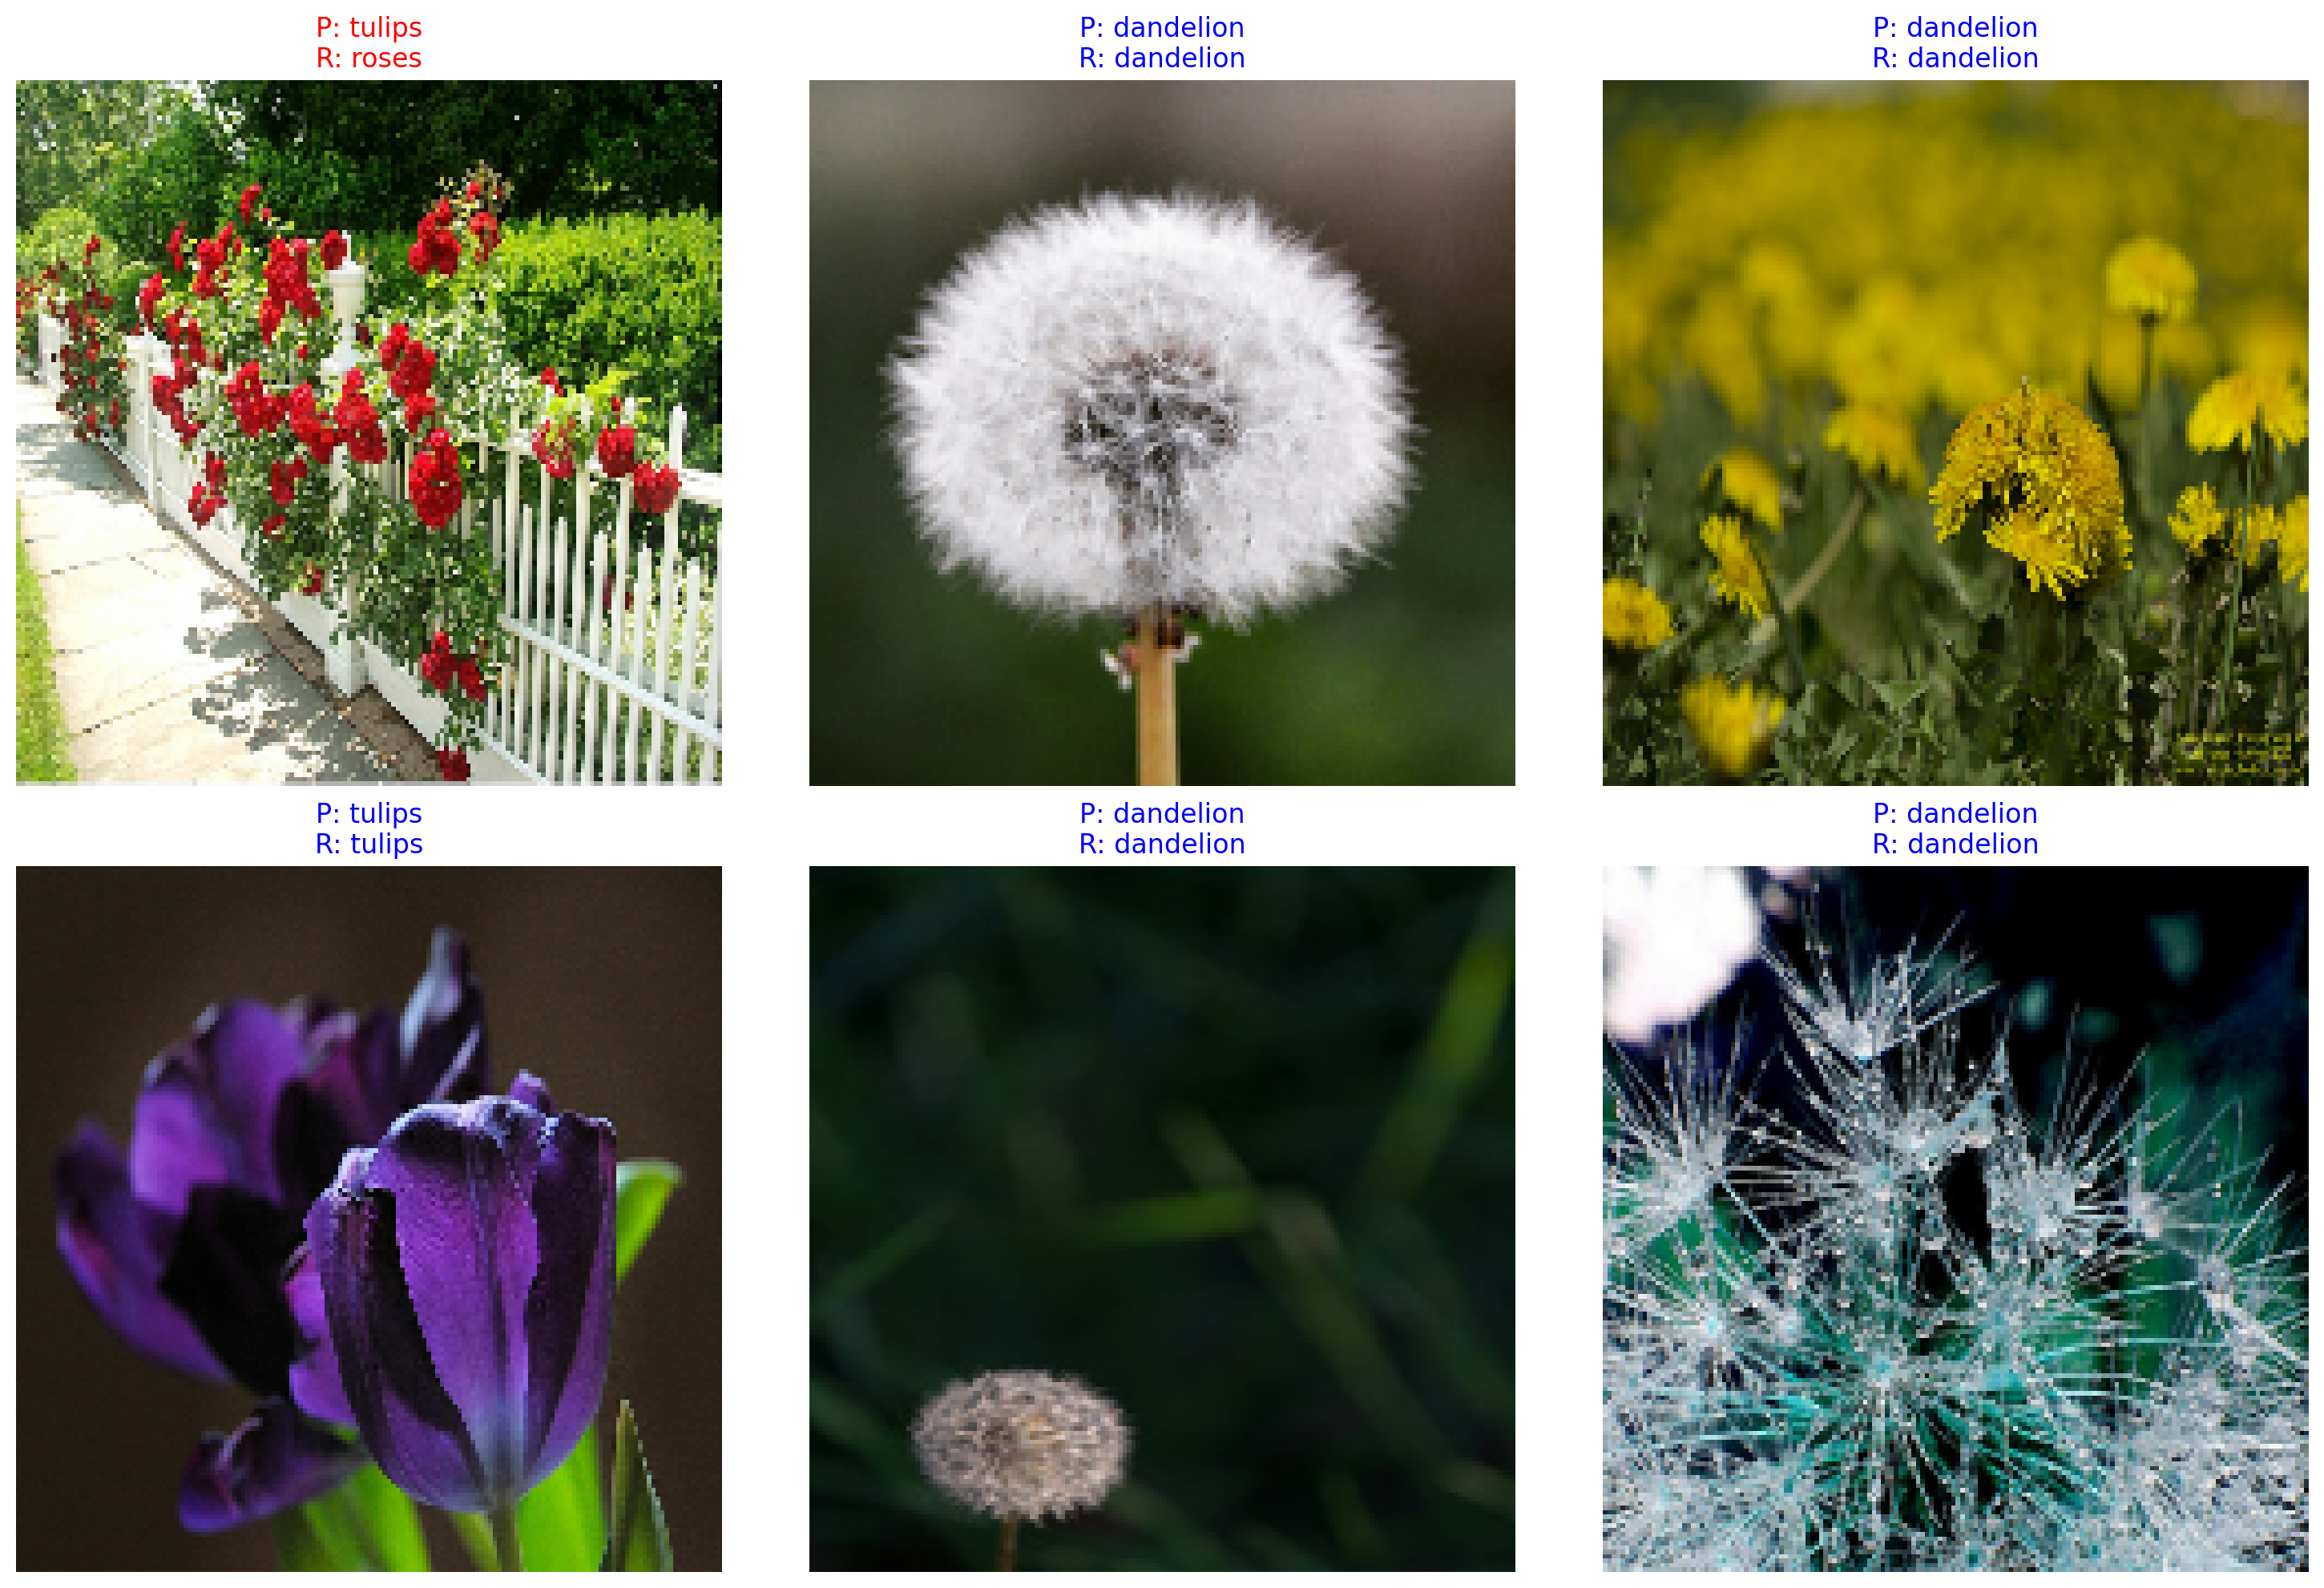

In [32]:
# 테스트 결과 시각화 출력
plt.figure(figsize=(15, 10))

for image_batch, label_batch in test_batches.take(1):
    predictions_raw = model.predict(image_batch)
    predictions = np.argmax(predictions_raw, axis=1)

    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(image_batch[i])

        correct = (predictions[i] == label_batch[i].numpy())
        color = 'blue' if correct else 'red'

        pred_name = metadata.features['label'].int2str(predictions[i])
        real_name = metadata.features['label'].int2str(label_batch[i].numpy())

        plt.title(f"P: {pred_name}\nR: {real_name}", color=color, fontsize=12)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [33]:
# 1. 초기화
total_correct = 0
total_samples = 0

# 2. 테스트 데이터셋 전체를 순회하며 정답 개수 카운트
for images, labels in test_batches:
    # 모델 예측 수행
    predictions_raw = model.predict(images, verbose=0)
    # 확률값 중 가장 높은 클래스 인덱스 추출 (0~4)
    predictions = np.argmax(predictions_raw, axis=1)

    # 루프를 통한 개별 비교 및 카운트
    for label, prediction in zip(labels.numpy(), predictions):
        if label == prediction:
            total_correct += 1
        total_samples += 1

# 3. 최종 정확도 계산 및 출력
final_score = (total_correct / total_samples) * 100

print(f"최종 정답 개수: {total_correct} / {total_samples}")
print(f"최종 테스트 정확도: {final_score:.2f}%")

최종 정답 개수: 335 / 367
최종 테스트 정확도: 91.28%


## 과적합 여부 확인
- 훈련 정확도 vs. 검증 정확도 차이 확인하기

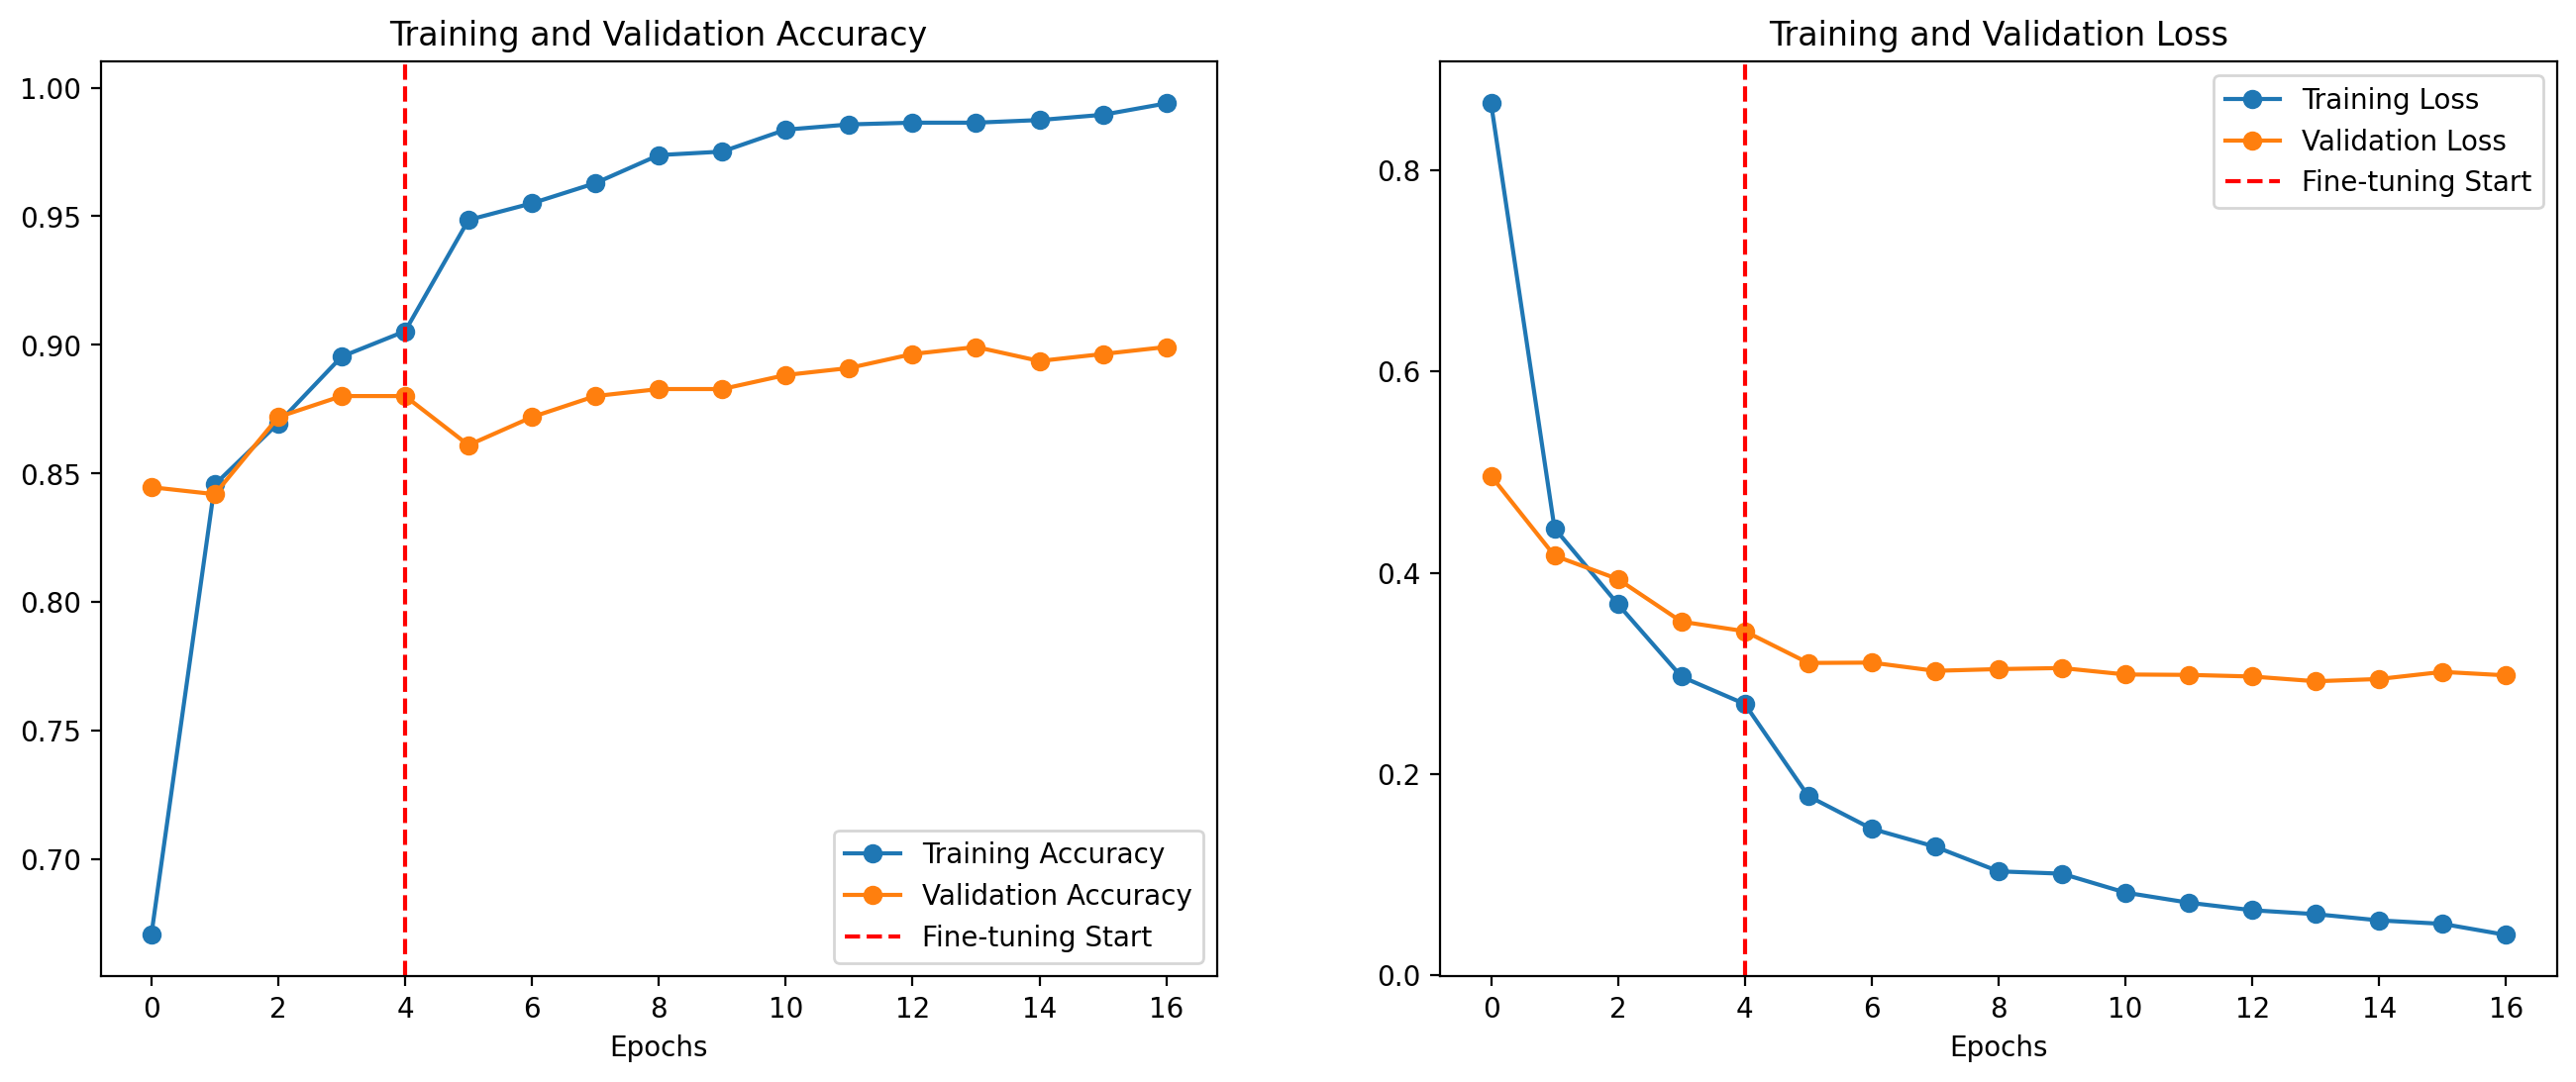

In [34]:
# 파인튜닝 전(history)과 후(history_final) 기록 합치기
all_acc = history.history['accuracy'] + history_final.history['accuracy']
all_val_acc = history.history['val_accuracy'] + history_final.history['val_accuracy']
all_loss = history.history['loss'] + history_final.history['loss']
all_val_loss = history.history['val_loss'] + history_final.history['val_loss']

plt.figure(figsize=(16, 6))

# Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(all_acc, label='Training Accuracy', marker='o')
plt.plot(all_val_acc, label='Validation Accuracy', marker='o')
plt.axvline(x=len(history.history['accuracy'])-1, color='r', linestyle='--', label='Fine-tuning Start')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(all_loss, label='Training Loss', marker='o')
plt.plot(all_val_loss, label='Validation Loss', marker='o')
plt.axvline(x=len(history.history['loss'])-1, color='r', linestyle='--', label='Fine-tuning Start')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

[ 과적합 점검 ]
- Fine-tunning 시작한 4 epoch 이후, train은 1에 임박하여 성능이 상승하는 반면, \
  Val.은 거의 평행을 유지하며 안정적인 성능 유지
- 최종적으로 train은 정확도가 거의 1에 도달했음에도 val.은 0.91 근처에서 유지 중 \
  -> 훈련 데이터에 과적합되지 않고 약 90%의 일반화 성능을 갖췄다고 판단할 수 있음
- Train의 손실값은 4 epoch 이후 거의 0.1 이하로 떨어지는 반면, \
  Val.의 손실값은 0.3에서 하락을 멈추고 평행을 유지하며 학습 종료

**결과적으로 과적합 없이 일반화 성능을 갖춘 모델 판단**

## 혼동행렬 확인

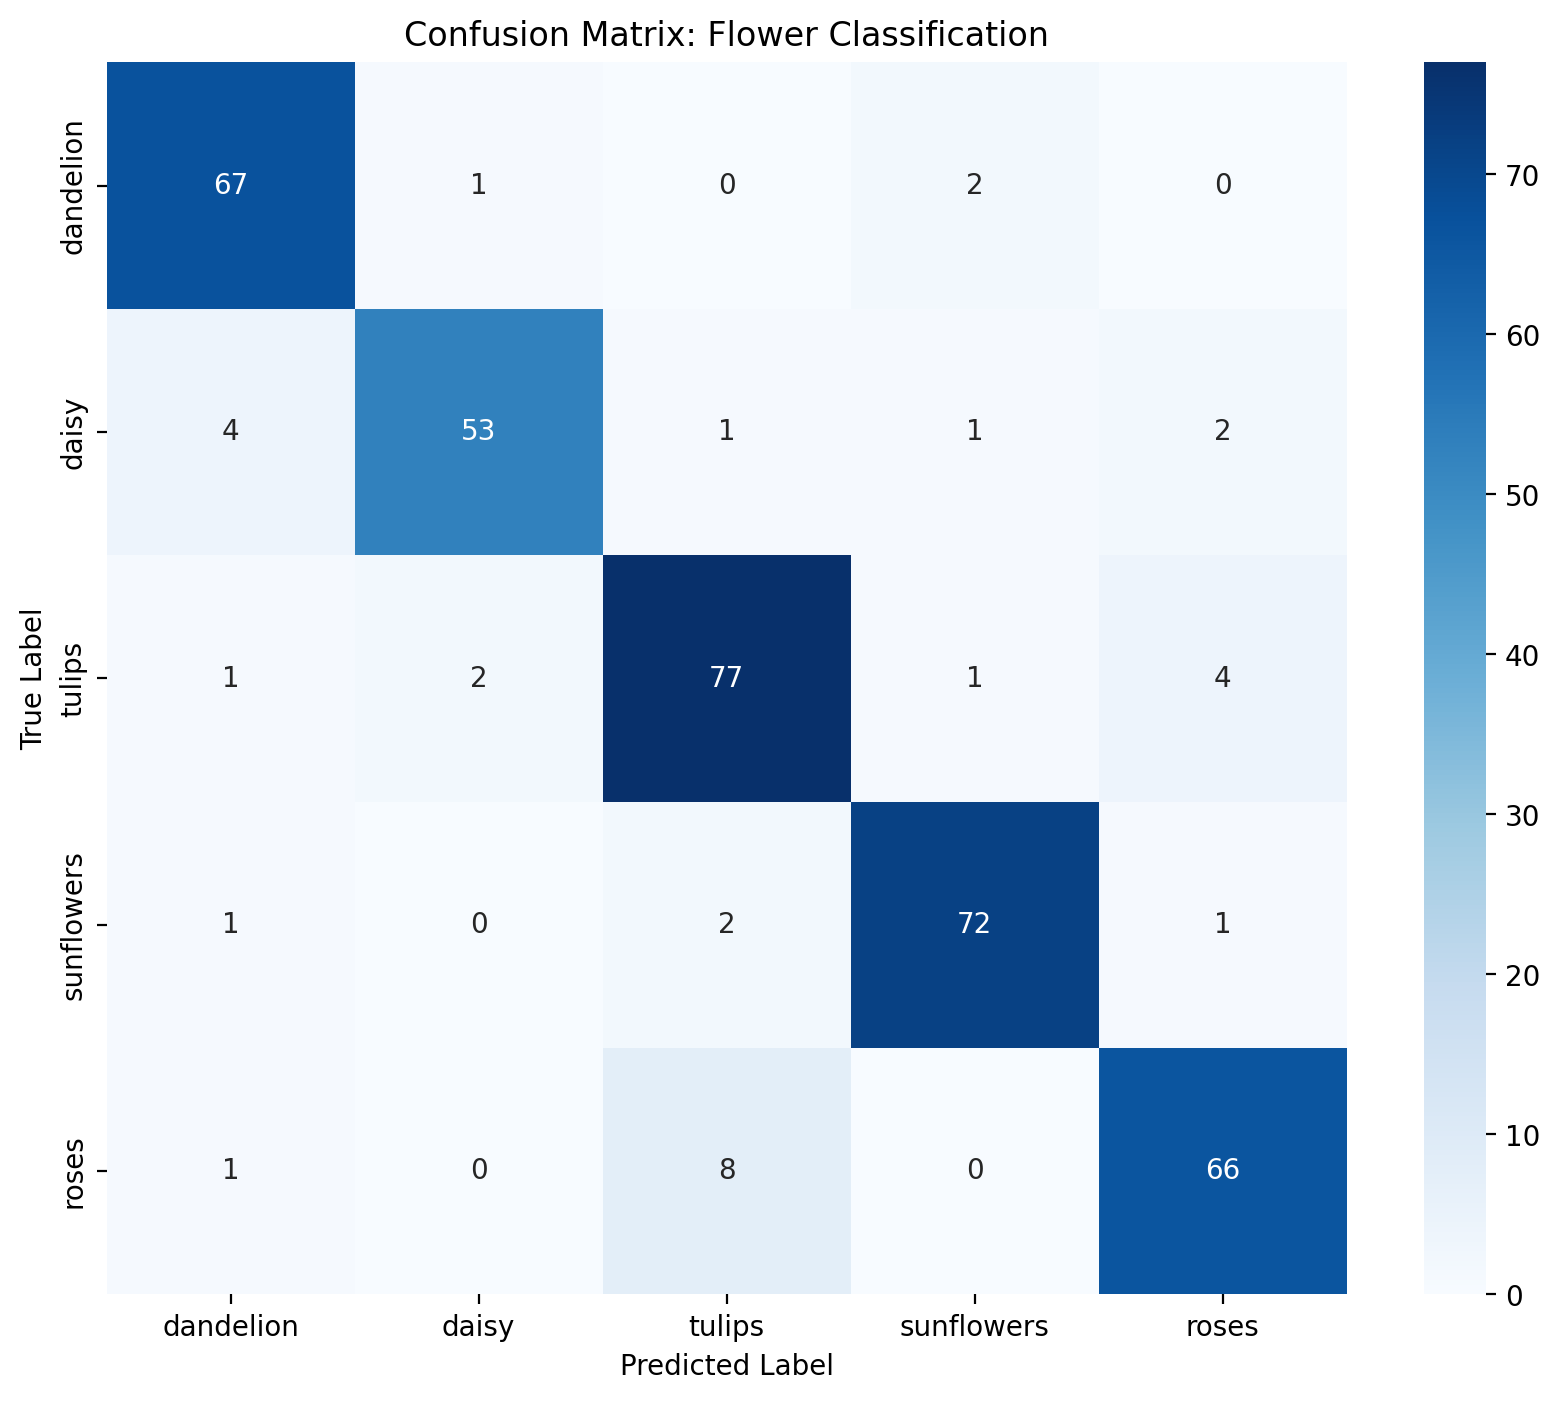

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. 전체 테스트 데이터셋에 대한 예측값과 실제값 모으기
all_labels = []
all_preds = []

for images, labels in test_batches:
    preds_raw = model.predict(images, verbose=0)
    preds = np.argmax(preds_raw, axis=1)

    all_labels.extend(labels.numpy())
    all_preds.extend(preds)

# 2. 혼동 행렬 계산
cm = confusion_matrix(all_labels, all_preds)

# 3. 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=metadata.features['label'].names,
            yticklabels=metadata.features['label'].names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Flower Classification')
plt.show()

[ 혼동행렬 점검 ]
- 나의 모델은 튤립에 대한 특징을 가장 잘 파악하여, 오답이 많이 없는 편
- 단, 실제 사진에서도 본 것처럼 튤립 같이 생긴 장미는 사람도 헷갈릴 지경이라 이 모델도 잘못 예측하는 경우가 6건 있음
- 또한 너무 해바라기처럼 활짝 펴 있는 민들레 사진도 오해할만 하나.. 성능을 좀 더 높일 수 있는 방법 모색 필요

In [36]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,081 (22.89 MB)

 Trainable params: 1,867,845 (7.13 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 3,735,692 (14.25 MB)

In [37]:
print("레이어별 학습 가능 여부 확인:")
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name:20} | Trainable: {layer.trainable}")

레이어별 학습 가능 여부 확인:
0: mobilenetv2_1.00_160 | Trainable: True
1: global_average_pooling2d_1 | Trainable: True
2: dropout              | Trainable: True
3: dense_2              | Trainable: True
